# Function-to-function fitting with Gaussian processes

We take a univariate function in input $f(t)$ and map it to a univariate function in output $g(t)$. We do so my sampling the two functions at the same points $t_1,t_2,\dots,t_n$.

To do so, we take a collections of $N_f$ functions and map them suitably.

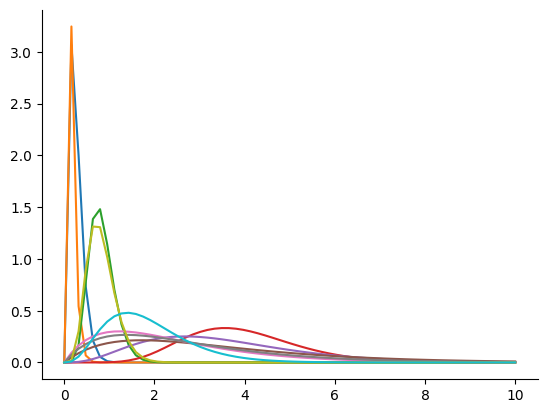

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.special import factorial

def schulz(x,mean, z):
    return 1/factorial(z)*((z+1)/mean)**(z+1)*x**z*np.exp(-(z+1)/mean*x)
# take a discrete number of points
npoints = 64
tmin, tmax = 0, 10 
t = np.linspace(tmin, tmax, npoints)  # Time points for function sampling

# Number of training functions (N)
Nf = 200

zmin = 1
zmax = 10
# Generate input functions (e.g., sine functions with random noise)
f = np.array([schulz(t,np.random.uniform(0,tmax/2.5), np.random.randint(zmin,zmax)) for _ in range(Nf)])  # Shape (N, npoints)
# Arbitrary test function outside of the training set (e.g. a z parameter larger than the range above)
f_test = schulz(t,2.1,zmax)  # 
for _ in f[:10]:
    plt.plot(t,_)


The array now has shape $N_f\times n$

In [2]:
f.shape

(200, 64)

A define here a simple transformation of the dataset via a rather nonlinear function


$$g = \log{f}+ \log{f}^2+ \log{f}^3$$

(notice that we introduce a small epsilon to avoid zeros)

In [3]:

def transform(u, eps=1e-3):
    F = np.log(u+eps)
    return F+F**2+F**3
    
# Generate output functions (e.g., cosine functions with a shift)
g = np.array([transform(_f) for _f in f])  # Shape (N, npoints)


Again, they should have the same shape as $f$ (every $f$ maps to one $g$)

In [4]:
g.shape

(200, 64)

We then identify the training input $X$ with $f$ and the output $Y$ with $g$

In [5]:
X = f  # Use the input functions directly as the input for the GP
Y = g  # Use the corresponding output functions


The Gaussian process models the similarity between two sample functions. These are measured from the distance between them, defined in the simplest form as the norm squared of the difference between them

$$||f_i(t)-f_j(t)||^2$$

We then take a **Radial Basis Function** to model these correlations 

$$K\left(f_i, f_j\right)=\exp \left(-\frac{1}{2 \sigma^2}\left\|f_i-f_j\right\|^2\right)$$

with parameter $\sigma$ that controls the scaling of the function.

This function (combined eventually with a prefactor $C$) yields the actual covariance between the two input functions. It is the parameters of this kernel that are optimised when the model is trained. Notice that we critically need to calculate a distance between two function and we clearly make a choice there. Preprocessing the inputs can therefore be important.

<!-- The objective function is the negative lof marginal likelihood

$$\mathcal{L}(\theta)=\frac{1}{2} g^T K_\theta^{-1} g+\frac{1}{2} \log \left|K_\theta\right|+\frac{N_f}{2} \log (2 \pi)$$

where $\theta$ represents all the parameters that enter the kernel (e.g. the prefactor $C$ and $\sigma$). -->

In [6]:
# Define a kernel for the GP (RBF kernel with constant term)
kernel = C(1.0) * RBF(1.0)#   # Combination of constant and RBF kernels, with their initial values


In [7]:
kernel(X).shape

(200, 200)

Check that we can calculate for example one entry:

In [8]:
print("covariance between 0 and 1 (from kernel)",kernel(X)[0,1])
print("covariance between 0 and 1 (from direct calculation)", 1.*np.exp(-np.sum((f[0]-f[1])**2)/(2*1.) ))

covariance between 0 and 1 (from kernel) 0.2675406139440693
covariance between 0 and 1 (from direct calculation) 0.26754061394406914


We can train the model in one go, but paying atention to the potential need for good hyperparameters (e.g. the number of restarts for the optimiser)

In [9]:


# Initialize the Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel,
                              n_restarts_optimizer=10,
                              alpha=0.13265817 #may want to manually fiddle with this hyperparameter in the presence of noise
                              
                              )

# Train the GP using scikit-learn
gp.fit(X, Y)


GaussianProcessRegressor(alpha=0.13265817, kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

The objective function in general is 

$$\mathcal{L}(\theta)=\frac{1}{2} \mathbf{y}^T K_\theta^{-1} \mathbf{y}+\frac{1}{2} \log \left|K_\theta\right|+\frac{n}{2} \log (2 \pi)$$

Since we have many  outputs (in fact, $n$) the way `scikit-learn` proceed is to calculate a likelihood for every column of the output Y and then sum. This means that we do not include explicit correlations between, for instance,  $t_1$ and $t_2$ and contributions of differnet times are all encoded in the evaluation of the radial basis function.

In [10]:
def log_marginal_likelihood_explicit(Y, K):
    """
    Compute the log marginal likelihood explicitly using matrix inversion 
    and a for loop over the target dimensions.

    Parameters:
    Y : ndarray of shape (n, d)
        Output matrix, where n is the number of samples and d is the number of targets.
    K : ndarray of shape (n, n)
        Kernel matrix (including noise variance, i.e., K + sigma^2 I).

    Returns:
    log_lml : float
        Log marginal likelihood for the dataset.
    """
    n, d = Y.shape

    # Explicit matrix inversion
    K_inv = np.linalg.inv(K)

    # Initialize the log marginal likelihood
    log_lml = 0.0

    # Loop over each target dimension (column of Y)
    for j in range(d):
        y_j = Y[:, j]  # Extract the j-th target vector (shape: n,)
        
        # Data fit term for this dimension
        log_lml += -0.5 * np.dot(y_j.T, np.dot(K_inv, y_j))  # y_j^T * K^-1 * y_j

    # Complexity penalty term
    log_det_K = np.linalg.slogdet(K)[1]  # Log determinant of K
    log_lml += -0.5 * d * log_det_K

    # Constant term
    log_lml += -0.5 * n * d * np.log(2 * np.pi)

    return log_lml

log_marginal_likelihood = gp.log_marginal_likelihood(gp.kernel_.theta)
print("log marginal likelihood from sklearn",log_marginal_likelihood)
print("log marginal likelihood from numpy",log_marginal_likelihood_explicit(Y, gp.kernel_(X) + gp.alpha * np.eye(len(X)) ))

log marginal likelihood from sklearn -35486.70279893473
log marginal likelihood from numpy -35486.70279924537


We can then test the model on our test dataset. Depending on the hyperparameters (and size of the dataset) it may be more or less susccessful (and take more or less time).

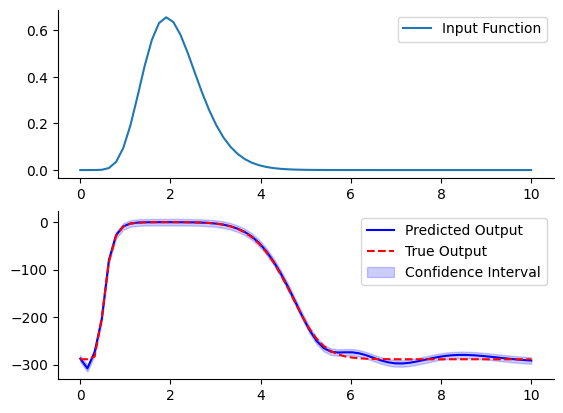

In [11]:


# Predict output for the new test function
g_pred, g_std = gp.predict(f_test.reshape(1, -1), return_std=True)


# Plot the results
fig, ax = plt.subplots(2, 1)

ax[0].plot(t, f_test, label="Input Function")
ax[0].legend()

ax[1].plot(t, g_pred.flatten(), label="Predicted Output", color='blue')
ax[1].plot(t, transform(f_test), label="True Output", linestyle='dashed', color='red')
ax[1].fill_between(t, g_pred.flatten() - 2 * g_std.flatten(), 
                   g_pred.flatten() + 2 * g_std.flatten(), 
                   color='blue', alpha=0.2, label="Confidence Interval")
ax[1].legend()

plt.show()


# Convert to another Gaussian process package (`GPy`) 

We are not bound to use `scikit-learn`. In fact, a faster and more robust package exists, and is provided by a dedicated (but less well documented) package called `gpy`

In [12]:
import numpy as np
import GPy
import matplotlib.pyplot as plt

# Define a kernel for the GP
kernel = GPy.kern.RBF(input_dim=X.shape[1], lengthscale=1.0) 

# Train the GP using GPy
model = GPy.models.GPRegression(X, Y, kernel)
model.optimize(messages=True)


# Predict output for the new test function
g_pred, g_var = model.predict(np.array([f_test]))  


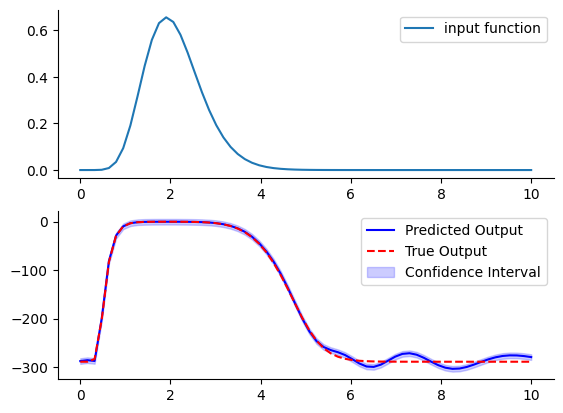

In [13]:

# Plot the results
fig,ax  = plt.subplots(2,1)
ax[0].plot(t,f_test, label="input function")
ax[0].legend()
ax[1].plot(t, g_pred.flatten(), label="Predicted Output", color='blue')
ax[1].plot(t, transform(f_test), label="True Output", linestyle='dashed', color='red')
ax[1].fill_between(t, g_pred.flatten() - 2 * np.sqrt(g_var.flatten()), 
                 g_pred.flatten() + 2 * np.sqrt(g_var.flatten()), 
                 color='blue', alpha=0.2, label="Confidence Interval")
plt.legend()
plt.show()
